Elbow Method Analysis: 100%|██████████| 18/18 [00:05<00:00,  3.47it/s]


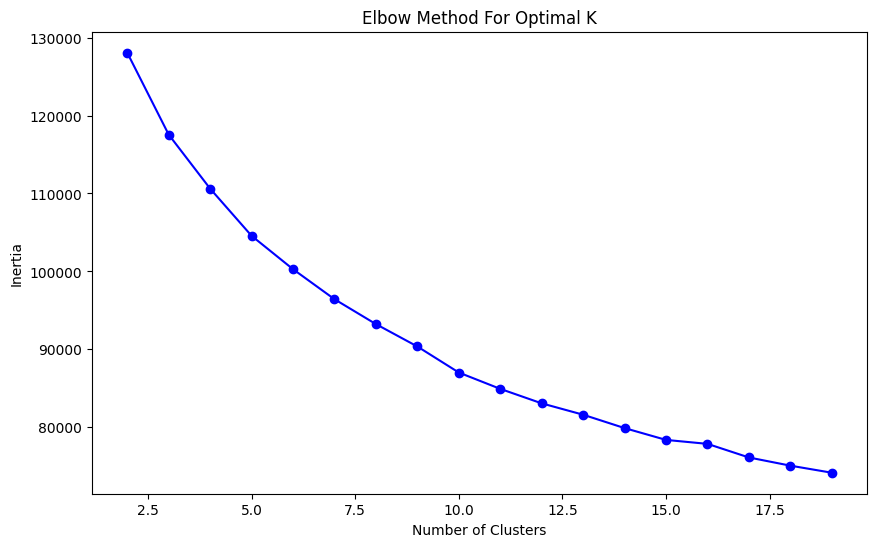

Recommendations for 'Shape of You':
            track_name      artists  popularity track_genre
541             _WORLD    SEVENTEEN          78       k-pop
971         Blue Flame  LE SSERAFIM          75       k-pop
685        Sour Grapes  LE SSERAFIM          77       k-pop
917  PLAYING WITH FIRE    BLACKPINK          75       k-pop
92      Talk that Talk        TWICE          86       k-pop
566         28 Reasons       SEULGI          78       k-pop
395             TOMBOY     (G)I-DLE          80       k-pop
916         Pied Piper          BTS          75       k-pop
253           CASE 143   Stray Kids          82       k-pop
676     Yeah Yeah Yeah    BLACKPINK          77       k-pop
Mean Precision: 0.87
Mean Recall: 0.03


Tuning Alpha Parameter: 100%|██████████| 9/9 [00:11<00:00,  1.22s/it]


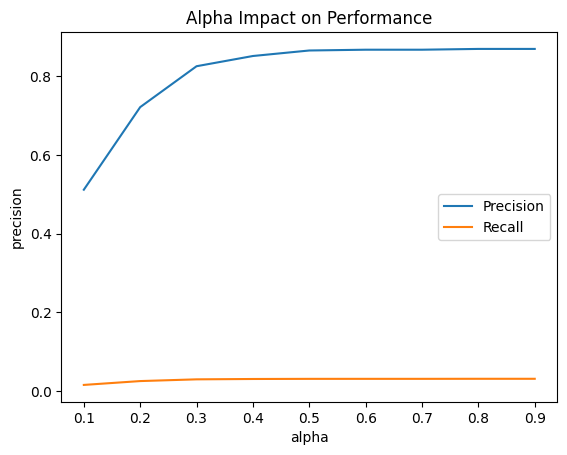

Models saved successfully!


In [16]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import joblib
import os

# =============================
# Data Preprocessing Functions
# =============================

def preprocess_data(input_path='../data/tracks_records.csv'):
    """
    Perform a full preprocessing pipeline on music data.

    Args:
        input_path (str): Path to the input CSV file containing music track data.

    Returns:
        tuple: A tuple containing:
            - processed DataFrame (with reset index),
            - TF-IDF matrix for the 'track_genre' column,
            - Scaled numeric features array,
            - StandardScaler object,
            - TfidfVectorizer object.
    """
    if not os.path.exists(input_path):
        raise FileNotFoundError(f"File not found at {input_path}")
    
    # Load dataset
    tracks = pd.read_csv(input_path)
    
    # Data cleaning: remove missing values and duplicate song entries.
    # Use 'track_name' as the identifier for duplicate removal.
    tracks = tracks.drop_duplicates(subset=['track_name'], keep='first')
    tracks = tracks.dropna()
    
    # Limit to top 10,000 songs based on popularity
    tracks = tracks.sort_values(by='popularity', ascending=False).head(10000)
    
    # Reset index so that it matches the feature matrix indices (0 to n-1)
    tracks = tracks.reset_index(drop=True)
    
    # Extract text features from the 'track_genre' column using TF-IDF.
    tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
    genre_matrix = tfidf.fit_transform(tracks['track_genre'].fillna(''))
    
    # Identify numeric columns and scale their features.
    numeric_cols = tracks.select_dtypes(include=[np.number]).columns.tolist()
    numeric_features = tracks[numeric_cols].values
    scaler = StandardScaler()
    numeric_features_scaled = scaler.fit_transform(numeric_features)
    
    return tracks, genre_matrix, numeric_features_scaled, scaler, tfidf

# ===================================
# Similarity Computation Functions
# ===================================

def hybrid_similarity(song_index, text_matrix, numeric_matrix, alpha=0.5):
    """
    Compute a hybrid similarity score combining TF-IDF based text features and numeric features.

    Args:
        song_index (int): Index of the target song.
        text_matrix (scipy.sparse.csr_matrix): TF-IDF vectorized text features.
        numeric_matrix (np.array): Scaled numeric features.
        alpha (float): Weight for text similarity (0 <= alpha <= 1).

    Returns:
        np.array: Combined similarity scores for all songs.
    """
    # Text similarity using cosine similarity
    text_sim = cosine_similarity(text_matrix[song_index], text_matrix).flatten()
    
    # Numeric similarity using cosine similarity
    numeric_sim = cosine_similarity(
        numeric_matrix[song_index].reshape(1, -1),
        numeric_matrix
    ).flatten()
    
    return alpha * text_sim + (1 - alpha) * numeric_sim

def compute_llm_similarity(song_index, text_matrix, numeric_matrix,
                           genre_embeddings, artist_embeddings,
                           alpha=0.4, beta=0.3, gamma=0.3):
    """
    Compute a combined similarity score that merges traditional similarity
    with LLM-generated genre and artist embeddings.

    Args:
        song_index (int): Index of the target song.
        text_matrix (scipy.sparse.csr_matrix): TF-IDF vectorized text features.
        numeric_matrix (np.array): Scaled numeric features.
        genre_embeddings (np.array): Array of LLM-generated genre embeddings.
        artist_embeddings (np.array): Array of LLM-generated artist embeddings.
        alpha (float): Weight for traditional similarity.
        beta (float): Weight for genre-based similarity.
        gamma (float): Weight for artist-based similarity.

    Returns:
        np.array: The combined similarity scores across all songs.
    """
    traditional = hybrid_similarity(song_index, text_matrix, numeric_matrix, alpha=0.5)
    genre_sim = cosine_similarity(
        genre_embeddings[song_index].reshape(1, -1),
        genre_embeddings
    ).flatten()
    artist_sim = cosine_similarity(
        artist_embeddings[song_index].reshape(1, -1),
        artist_embeddings
    ).flatten()
    
    return (alpha * traditional) + (beta * genre_sim) + (gamma * artist_sim)

# ===================================
# Recommendation Evaluation Functions
# ===================================

def evaluate_recommendations(song_name, tracks, text_matrix, numeric_matrix, alpha=0.6, top_n=10):
    """
    Evaluate recommendations for a given song using hybrid similarity.
    Only returns recommendations from the same cluster as the target song.

    Args:
        song_name (str): The track name to search for.
        tracks (DataFrame): Preprocessed track data with a 'cluster' column.
        text_matrix: TF-IDF matrix.
        numeric_matrix: Scaled numeric features.
        alpha (float): Weight parameter for similarity.
        top_n (int): Number of recommendations to return.

    Returns:
        DataFrame: Recommended tracks.
    """
    # Locate the target song by track_name
    song_row = tracks[tracks['track_name'] == song_name].iloc[0]
    song_index = song_row.name  # Now this index is within range after resetting
    song_cluster = song_row['cluster']
    
    # Filter songs in the same cluster
    cluster_songs = tracks[tracks['cluster'] == song_cluster]
    
    # Compute hybrid similarity scores for all songs
    sim_scores = hybrid_similarity(song_index, text_matrix, numeric_matrix, alpha=alpha)
    
    # Restrict scores to songs in the same cluster
    cluster_indices = cluster_songs.index
    cluster_scores = sim_scores[cluster_indices]
    
    # Sort and retrieve top_n indices (excluding the song itself)
    sorted_order = np.argsort(cluster_scores)[::-1]
    filtered_order = [i for i in sorted_order if cluster_indices[i] != song_index][:top_n]
    recommended_indices = cluster_indices[filtered_order]
    
    return tracks.loc[recommended_indices]

def calculate_metrics(tracks, text_matrix, numeric_matrix, sample_size=100, top_n=5, alpha=0.6):
    """
    Evaluate recommendation performance using simple precision and recall metrics.

    Args:
        tracks (DataFrame): Preprocessed track data.
        text_matrix: TF-IDF matrix.
        numeric_matrix: Scaled numeric features.
        sample_size (int): Number of songs to sample for evaluation.
        top_n (int): Number of recommendations per song.
        alpha (float): Weight parameter for similarity.

    Returns:
        tuple: Mean precision and recall.
    """
    precisions = []
    recalls = []
    
    test_songs = tracks.sample(sample_size, random_state=42)
    
    for song in test_songs.itertuples():
        # Define "actual" similar songs based on a simple criteria (popularity proximity and genre match)
        actual = tracks[
            (tracks['popularity'] >= song.popularity - 10) &
            (tracks['track_genre'].str.contains(song.track_genre.split(',')[0], case=False))
        ]
        recommended = evaluate_recommendations(song.track_name, tracks, text_matrix, numeric_matrix, alpha=alpha, top_n=top_n)
        
        relevant = set(actual.index)
        recommended_set = set(recommended.index)
        
        precision = len(relevant & recommended_set) / len(recommended_set) if recommended_set else 0
        recall = len(relevant & recommended_set) / len(relevant) if relevant else 0
        
        precisions.append(precision)
        recalls.append(recall)
    
    return np.mean(precisions), np.mean(recalls)

# ===================================
# Clustering Model Training and Saving Function
# ===================================

def train_and_save_clustering_model(numeric_features, n_clusters=12, model_path='../models/clustering_model.pkl'):
    """
    Train a KMeans clustering model on numeric features and save the model.
    
    Args:
        numeric_features (np.array): The scaled numeric features.
        n_clusters (int): Number of clusters to form.
        model_path (str): Path where the clustering model will be saved.
        
    Returns:
        KMeans: Trained KMeans model.
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(numeric_features)
    
    # Ensure the directory exists
    os.makedirs(os.path.dirname(model_path), exist_ok=True)
    joblib.dump(kmeans, model_path)
    print(f"Clustering model saved to {model_path}")
    return kmeans

# =============================================
# Main Execution: Preprocessing, Training, Evaluation, Tuning, and Saving
# =============================================

if __name__ == "__main__":
    # Preprocess the data and extract features from the CSV.
    tracks, genre_matrix, numeric_features_scaled, scaler, tfidf = preprocess_data('../data/tracks_records.csv')
    
    # ============================
    # 1. Clustering Model Training
    # ============================
    
    inertias = []
    K_range = range(2, 20)
    for k in tqdm(K_range, desc="Elbow Method Analysis"):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(numeric_features_scaled)
        inertias.append(kmeans.inertia_)
    
    plt.figure(figsize=(10, 6))
    plt.plot(K_range, inertias, 'bo-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Method For Optimal K')
    plt.show()
    
    optimal_k = 12  # Set based on elbow plot observation
    final_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    clusters = final_kmeans.fit_predict(numeric_features_scaled)
    tracks['cluster'] = clusters
    
    # ============================
    # 2. Similarity Model Development
    # ============================
    # (Using the hybrid_similarity function defined above)
    
    # ============================
    # 3. Recommendation Evaluation
    # ============================
    
    sample_song = "Shape of You"  # Replace with a valid track_name from your data
    recs = evaluate_recommendations(sample_song, tracks, genre_matrix, numeric_features_scaled, alpha=0.6, top_n=10)
    print(f"Recommendations for '{sample_song}':")
    print(recs[['track_name', 'artists', 'popularity', 'track_genre']])
    
    precision, recall = calculate_metrics(tracks, genre_matrix, numeric_features_scaled, sample_size=100, top_n=5, alpha=0.6)
    print(f"Mean Precision: {precision:.2f}")
    print(f"Mean Recall: {recall:.2f}")
    
    # ============================
    # 4. Hyperparameter Tuning
    # ============================
    
    alphas = np.linspace(0.1, 0.9, 9)
    results = []
    for a in tqdm(alphas, desc="Tuning Alpha Parameter"):
        prec, rec = calculate_metrics(tracks, genre_matrix, numeric_features_scaled, sample_size=100, top_n=5, alpha=a)
        results.append({'alpha': a, 'precision': prec, 'recall': rec})
    
    results_df = pd.DataFrame(results)
    sns.lineplot(data=results_df, x='alpha', y='precision', label='Precision')
    sns.lineplot(data=results_df, x='alpha', y='recall', label='Recall')
    plt.title('Alpha Impact on Performance')
    plt.show()
    
    # ============================
    # 5. Final Model Training and Saving
    # ============================
    
    # Retrain final clustering model
    final_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    final_clusters = final_kmeans.fit_predict(numeric_features_scaled)
    tracks['cluster'] = final_clusters
    
    # Ensure model directory exists and save models
    os.makedirs('../models', exist_ok=True)
    joblib.dump(final_kmeans, '../models/clustering_model.pkl')
    joblib.dump(tfidf, '../models/tfidf_vectorizer.pkl')
    joblib.dump(scaler, '../models/standard_scaler.pkl')
    
    print("Models saved successfully!")
